In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
# Technically not necessary in newest versions of jupyter
%matplotlib inline

In [2]:
my_data_dir = '/Users/rakeshmohansharma/Downloads/cell_images'

In [3]:
os.listdir(my_data_dir) 

['test', 'train']

In [4]:
test_path = my_data_dir+'/test/'
train_path = my_data_dir+'/train/'

In [6]:
print(os.listdir(test_path))
print(os.listdir(train_path))

['parasitized', 'uninfected']
['parasitized', 'uninfected']


## let's view an image 

In [7]:
os.listdir(train_path+'/parasitized')[0]

'C189P150ThinF_IMG_20151203_142224_cell_84.png'

In [8]:
para_cell = train_path+'/parasitized'+'/C189P150ThinF_IMG_20151203_142224_cell_84.png'

In [11]:
para_img.shape

(121, 118, 3)

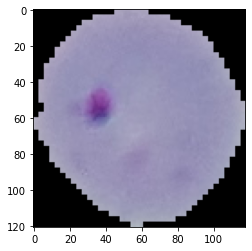

In [10]:
para_img= imread(para_cell)
plt.imshow(para_img)

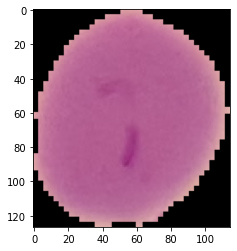

In [12]:
unifected_cell_path = train_path+'/uninfected/'+os.listdir(train_path+'/uninfected')[0]
unifected_cell = imread(unifected_cell_path)
plt.imshow(unifected_cell)

In [13]:
len(os.listdir(train_path+'/parasitized'))

12480

In [14]:
len(os.listdir(train_path+'/uninfected'))

12480

### lets find out the av dimensions of the images 

In [15]:
unifected_cell.shape

(127, 115, 3)

In [16]:
para_img.shape

(121, 118, 3)

In [17]:
dim1 = []
dim2 = []
for image_filename in os.listdir(test_path+'/uninfected'):
    
    img = imread(test_path+'/uninfected'+'/'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

/Users/rakeshmohansharma/tensorflow-test/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


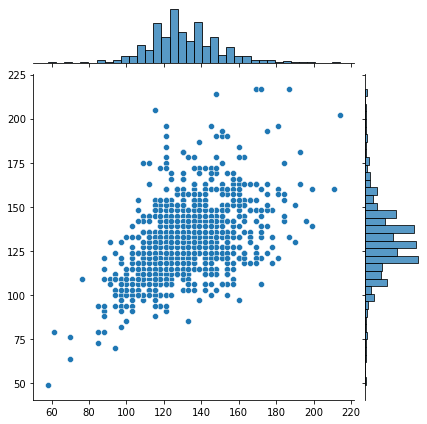

In [20]:
sns.jointplot(dim1,dim2)

In [21]:
np.mean(dim1)

130.92538461538462

In [22]:
np.mean(dim2)

130.75

In [23]:
image_shape = (130,130,3)

## Preparing the Data for the model

There is too much data for us to read all at once in memory. We can use some built in functions in Keras to automatically process the data, generate a flow of batches from a directory, and also manipulate the images.

### Image Manipulation

Its usually a good idea to manipulate the images with rotation, resizing, and scaling so the model becomes more robust to different images that our data set doesn't have. We can use the **ImageDataGenerator** to do this automatically for us.

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [26]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               
                               rescale=1/255, # Rescale the image by normalzing it.
                               
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               
                               zoom_range=0.1, # Zoom in by 10% max
                               
                               horizontal_flip=True, # Allow horizontal flipping
                               
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

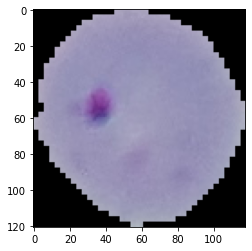

In [27]:
plt.imshow(para_img)

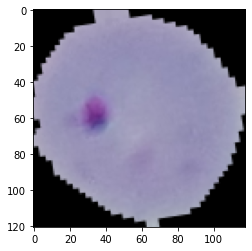

In [28]:
plt.imshow(image_gen.random_transform(para_img))

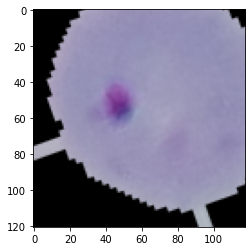

In [29]:
plt.imshow(image_gen.random_transform(para_img))

In [30]:
train_path

'/Users/rakeshmohansharma/Downloads/cell_images/train/'

In [31]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [34]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


## creating the model 

In [36]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Flatten, Dense, MaxPool2D, Conv2D, Reshape, Dropout,Activation

In [38]:
model = Sequential([
    Conv2D(filters = 32, kernel_size =(3,3), input_shape = image_shape, activation ='relu'), 
    MaxPool2D(pool_size =(2,2)), 
    
    Conv2D(filters =64, kernel_size =(3,3), input_shape = image_shape, activation ='relu'), 
    MaxPool2D(pool_size =(2,2)), 
    
    Conv2D(filters =64, kernel_size =(3,3), input_shape = image_shape, activation ='relu'), 
    MaxPool2D(pool_size =(2,2)), 
    
    Flatten(), 
    
    Dense(128, activation ='relu'), 
    
    Dropout(0.5), 
    Dense(1, activation ='sigmoid'),
])

Metal device set to: Apple M1


2022-07-09 10:51:24.626243: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-09 10:51:24.628035: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [39]:
model.compile(loss='binary_crossentropy', optimizer ='adam', metrics =['accuracy'])

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [42]:
from tensorflow.keras.callbacks import EarlyStopping

In [44]:
early = EarlyStopping(monitor ='val_loss', patience =2)

In [45]:
batch_size = 16

In [52]:
train_im_gen = image_gen.flow_from_directory(train_path, target_size =(130,130), color_mode ='rgb', batch_size =16, class_mode='binary')
test_im_gen = image_gen.flow_from_directory(test_path, target_size =(130,130), color_mode ='rgb', batch_size =16,shuffle=False, class_mode='binary')

Found 24958 images belonging to 2 classes.
Found 2600 images belonging to 2 classes.


In [53]:
train_im_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [54]:
results = model.fit_generator(train_im_gen, epochs =15, validation_data =test_im_gen, callbacks =[early])

/var/folders/65/ft7c6wm901n95b07b65h4xgw0000gn/T/ipykernel_16667/2283881484.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results = model.fit_generator(train_im_gen, epochs =15, validation_data =test_im_gen, callbacks =[early])


Epoch 1/15


2022-07-09 12:09:55.536620: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-09 12:09:56.397399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1560/1560 [==============================] - ETA: 0s - loss: 0.3236 - accuracy: 0.8566

2022-07-09 12:12:31.046783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1560/1560 [==============================] - 167s 104ms/step - loss: 0.3236 - accuracy: 0.8566 - val_loss: 0.1907 - val_accuracy: 0.9377
Epoch 2/15
1560/1560 [==============================] - 146s 94ms/step - loss: 0.1829 - accuracy: 0.9433 - val_loss: 0.1712 - val_accuracy: 0.9450
Epoch 3/15
1560/1560 [==============================] - 143s 92ms/step - loss: 0.1641 - accuracy: 0.9474 - val_loss: 0.1683 - val_accuracy: 0.9446
Epoch 4/15
1560/1560 [==============================] - 145s 93ms/step - loss: 0.1596 - accuracy: 0.9496 - val_loss: 0.1534 - val_accuracy: 0.9435
Epoch 5/15
1560/1560 [==============================] - 146s 94ms/step - loss: 0.1540 - accuracy: 0.9511 - val_loss: 0.1476 - val_accuracy: 0.9519
Epoch 6/15
1560/1560 [==============================] - 145s 93ms/step - loss: 0.1576 - accuracy: 0.9506 - val_loss: 0.1517 - val_accuracy: 0.9492
Epoch 7/15
1560/1560 [==============================] - 145s 93ms/step - loss: 0.1532 - accuracy: 0.9504 - val_loss: 0.1617 - va

## evaluating the model 

In [55]:
pred = model.predict_generator(test_im_gen)

/var/folders/65/ft7c6wm901n95b07b65h4xgw0000gn/T/ipykernel_16667/597620399.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model.predict_generator(test_im_gen)
2022-07-09 12:31:46.557558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [56]:
predictions = pred >0.8

In [57]:
predictions

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [58]:
from sklearn.metrics import classification_report, confusion_matrix

In [59]:
print(classification_report(test_im_gen.classes, predictions))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1300
           1       0.94      0.95      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



In [60]:
from tensorflow.keras.preprocessing import image

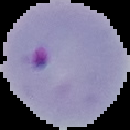

In [64]:
my_image = image.load_img(para_cell, target_size=image_shape)

In [86]:
my_image_arr = image.img_to_array(my_image)
my_image_arr.shape

(130, 130, 3)

In [87]:
my_image_arr= np.expand_dims(my_image_arr, axis=0)
my_image_arr.shape

(1, 130, 130, 3)

In [88]:
model.predict(my_image_arr)

2022-07-09 13:43:21.070774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 696ms/step


array([[0.]], dtype=float32)

In [90]:
train_im_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

### this mean that our sample is infected